# Урок 6. Градиентный бустинг

In [17]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

In [18]:
from sklearn.datasets import load_diabetes

In [19]:
X, y = load_diabetes(return_X_y=True)

In [20]:
X.shape

(442, 10)

In [21]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [22]:
def gb_predict(X, trees_list, coef_list, eta):
    return np.array([sum([eta*coef*alg.predict([x])[0] for alg, coef in zip(trees_list,coef_list)]) for x in X])


В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функицию.

In [23]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [24]:
def deriv(y, z):
    return 2*(y - z)

Реализуем функцию обучения градиентного бустинга.

In [25]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            pred = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, deriv(y_train, pred))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение.

In [26]:
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 1

# %%time
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [31]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} '
    f'с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} '
    f'с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [32]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 3 с шагом 1 на тренировочной выборке: 2729.357522136797
Ошибка алгоритма из 10 деревьев глубиной 3 с шагом 1 на тестовой выборке: 5836.548513094272


Построим графики зависимости ошибки на обучающей и тестовой выборках от числа итераций.

In [33]:
import matplotlib.pyplot as plt

In [34]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

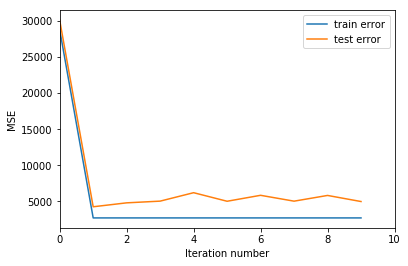

In [35]:
get_error_plot(n_trees, train_errors, test_errors)

Такой результат не является удовлетворительным

Увеличим число деревьев.

In [36]:
n_trees = 100
coefs = [1] * n_trees

# %%time
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [37]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 100 деревьев глубиной 3 с шагом 1 на тренировочной выборке: 2729.357522136796
Ошибка алгоритма из 100 деревьев глубиной 3 с шагом 1 на тестовой выборке: 5836.5485130942725


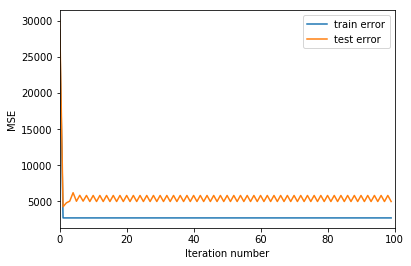

In [38]:
get_error_plot(n_trees, train_errors, test_errors)

Теперь попробуем уменьшить шаг.

In [39]:
eta = 0.1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [40]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 100 деревьев глубиной 3 с шагом 0.1 на тренировочной выборке: 329.20301550220614
Ошибка алгоритма из 100 деревьев глубиной 3 с шагом 0.1 на тестовой выборке: 4033.329568365328


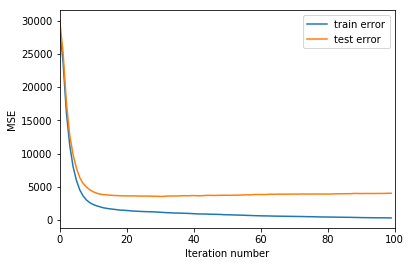

In [41]:
get_error_plot(n_trees, train_errors, test_errors)

Видим, что качество обучения улучшается.

Уменьшим шаг до 0.01.

In [42]:
eta = 0.01

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [43]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 100 деревьев глубиной 3 с шагом 0.01 на тренировочной выборке: 2418.703232699388
Ошибка алгоритма из 100 деревьев глубиной 3 с шагом 0.01 на тестовой выборке: 4416.653823050587


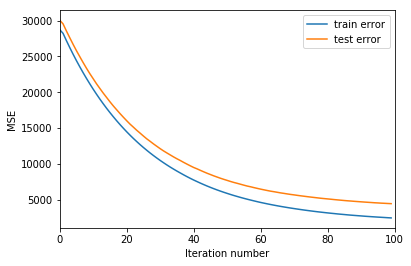

In [44]:
get_error_plot(n_trees, train_errors, test_errors)

При таком размере шага алгоритм сходится, но ему для достижения удовлетворительных показателей требуется большее количество итераций.

Вернемся к шагу 0.1 и попробуем увеличить глубину деревьев

In [45]:
eta = 0.1
max_depth = 5

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [46]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 100 деревьев глубиной 5 с шагом 0.1 на тренировочной выборке: 3.251584256807996
Ошибка алгоритма из 100 деревьев глубиной 5 с шагом 0.1 на тестовой выборке: 4639.136795810144


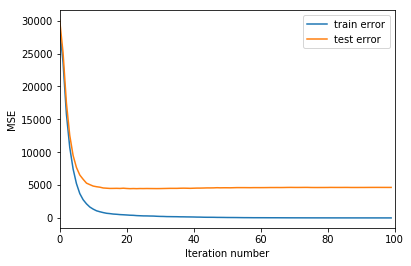

In [47]:
get_error_plot(n_trees, train_errors, test_errors)

## AdaBoost

In [48]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer

In [49]:
X, y = load_breast_cancer(return_X_y=True)

Разделим выборку на обучающую и тестовую

In [50]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Реализуем функцию подсчета ошибки

In [51]:
def get_error(pred, y):
    return sum(pred != y) / len(y)

И сам алгоритм

In [52]:
def adaboost(X, y, N):

    # Размер выборки
    n_objects = len(X)

    # Запишем количество классов в переменную
    n_classes = len(np.unique((y)))

    # Начальные веса деревьев
    w = np.ones(n_objects) / n_objects

    # Деревья с весами будем записывать в список
    models = []

    for n in range(N):
        # Зададим дерево и обучим его
        clf = DecisionTreeClassifier(max_depth=1)
        clf.fit(X, y, sample_weight=w)

        predictions = clf.predict(X)
        e = get_error(predictions, y)
        # отбросим дерево, если его ошибка больше 0.5
        # Запишем условие в общем виде (применимо к небинарным классификаторам)
        if e >= 1 - 1/n_classes: 
            break

        # Вычислим вес для дерева
        alpha = 0.5 * np.log((1 - e) / e)

        # Найдем индексы правильно классифицированных элементов
        match = predictions == y

        # Увеличим веса для неправильно классифицированных элементов
        w[~match] *= np.exp(alpha)

        # Нормализуем веса
        w /= w.sum()

        # Добавим дерево с весом в список
        models.append((alpha, clf))
    
    return models

Обучим алгоритм из 50 деревьев

In [53]:
N = 50

models = adaboost(X_train, y_train, N)

Теперь осуществим предсказание

In [54]:
def predict(X, models):
    
    n_classes = 2
    n_objects = len(X)
    
    # вначале обозначим предсказание нулевым массивом
    y_pred = np.zeros((n_objects, n_classes))
    
    for alpha, clf in models:
        prediction = clf.predict(X)
        # Для каждого предсказания будем прибавлять alpha к
        # элементу с индексом предсказанного класса
        y_pred[range(n_objects), prediction] += alpha
    
    # выберем индексы с максимальными суммарными весами -
    # получим предсказанные алгоритмом классы
    y_pred = np.argmax(y_pred, axis=1)
    
    return y_pred

print(f'Точность алгоритма на обучающей выборке: {(1 - get_error(predict(X_train, models), y_train)) * 100:.3f}')

Точность алгоритма на обучающей выборке: 96.479


In [55]:
print(f'Точность алгоритма на тестовой выборке: {(1 - get_error(predict(X_test, models), y_test)) * 100:.3f}')

Точность алгоритма на тестовой выборке: 94.406


Построим графики зависимости ошибки от количества базовых алгоритмов в ансамбле.

In [56]:
train_errors = []
test_errors = []

for n in range(1, 31):
    mods = adaboost(X_train, y_train, n)
    train_errors.append(get_error(predict(X_train, mods), y_train))
    test_errors.append(get_error(predict(X_test, mods), y_test))

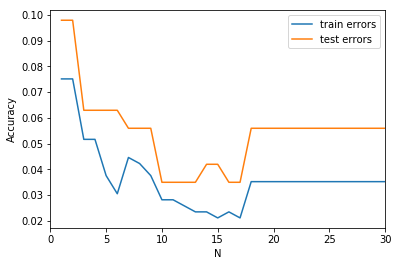

In [57]:
x = list(range(1, 31))

plt.xlim(0, 30)
plt.plot(x, train_errors, label='train errors')
plt.plot(x, test_errors, label='test errors')
plt.xlabel('N')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')

### Домашнее задание:  
1. Для реализованной модели построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.  
2. Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

**1. Для реализованной модели построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.**

Построим графики зависимости ошибки от количества деревьев в ансамбле 

In [196]:
X, y = load_diabetes(return_X_y=True)

In [197]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [198]:
def evaluate_alg2(X_train, X_test, y_train, y_test, trees, coefs, eta, max_depth):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    mse_train = mean_squared_error(y_train, train_prediction)

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    mse_test = mean_squared_error(y_test, test_prediction)
    
    return mse_train, mse_test

In [199]:
# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 0.1

In [200]:
n_trees = [1, 5, 10, 15, 20]
train_err = []
test_err = []
train_errors = []
test_errors = []

for n_tree in n_trees:
    # для простоты примем коэффициенты равными 1
    coefs = [1] * n_tree
    trees, train_errors, test_errors = gb_fit(n_tree, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    mse_train, mse_test = evaluate_alg2(X_train, X_test, y_train, y_test, trees, coefs, eta, max_depth)
    train_err.append(mse_train)
    test_err.append(mse_test)

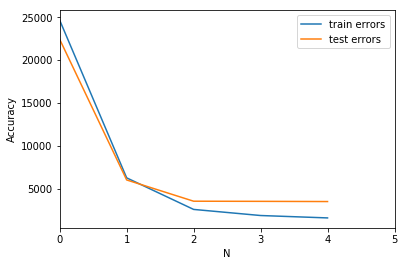

In [201]:
x = list(range(0, len(train_err)))

plt.xlim(0, len(train_err))
plt.plot(x, train_err, label='train errors')
plt.plot(x, test_err, label='test errors')
plt.xlabel('N')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')

In [202]:
min(train_err), min(test_err)

(1565.8912446266727, 3477.5673607915373)

Построим графики зависимости ошибки от максимальной глубины деревьев

In [203]:
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

In [204]:
# Максимальная глубина деревьев
max_depths = [3, 5, 7]
train_err = []
test_err = []
train_errors = []
test_errors = []

for max_depth in max_depths:
    trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    mse_train, mse_test = evaluate_alg2(X_train, X_test, y_train, y_test, trees, coefs, eta, max_depth)
    train_err.append(mse_train)
    test_err.append(mse_test)

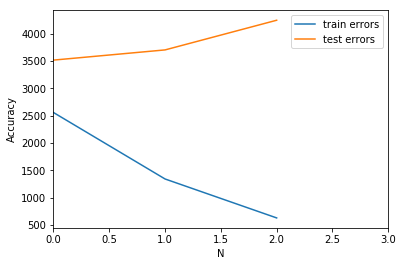

In [205]:
x = list(range(0, len(train_err)))

plt.xlim(0, len(train_err))
plt.plot(x, train_err, label='train errors')
plt.plot(x, test_err, label='test errors')
plt.xlabel('N')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')

**Выводы:**
    1. При увеличении количества деревьев в ансамбле ошибка уменьшается, как на тесте, так и на трейне.
    2. При увеличении максимальной глубины деревьев в ансамбле ошибка уменьшается на трейне и увеличивается на тесте. Возможно это связано с переобучением (оверфиттингом).

**2. Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.**

In [250]:
def gb_fit2(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):

    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            pred = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, deriv(y_train, pred))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [251]:
# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 0.1

In [252]:
n_trees = [1, 5, 10, 15, 20]
train_err = []
test_err = []
train_errors = []
test_errors = []

for n_tree in n_trees:
    coefs = [0.5] * n_tree
    trees, train_errors, test_errors = gb_fit2(n_tree, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    mse_train, mse_test = evaluate_alg2(X_train, X_test, y_train, y_test, trees, coefs, eta, max_depth)
    train_err.append(mse_train)
    test_err.append(mse_test)

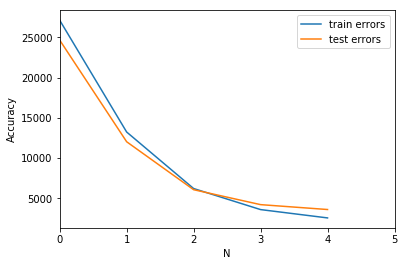

In [253]:
x = list(range(0, len(train_err)))

plt.xlim(0, len(train_err))
plt.plot(x, train_err, label='train errors')
plt.plot(x, test_err, label='test errors')
plt.xlabel('N')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')

In [254]:
min(train_err), min(test_err)

(2554.71235009471, 3598.4764283251457)

**Вывод:**
    Точность несколько снизилась (возрасла ошибка как на тесте, так и на трейне).